<a href="https://colab.research.google.com/github/avindumihisara0229-code/telco-churn-project/blob/main/telco_churn_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install required libraries

In [140]:
!pip install keras-tuner imbalanced-learn

In [141]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
import pandas as pd

# PATH
file_path = '/content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(file_path)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [143]:
# Import libraries for Task 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plotting style
sns.set_theme(style="whitegrid")

In [144]:
# Load the dataset
file_path = '/content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(file_path)

# Look at the first few rows
print("--- First 5 Rows ---")
display(df.head())

# Get information on columns and data types
print("\n--- Column Info (Data Types) ---")
df.info()

--- First 5 Rows ---


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



--- Column Info (Data Types) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  Paperles

In [145]:
# Drop 'customerID' column
df.drop('customerID', axis=1, inplace=True)

# Fix the 'TotalCharges' column
# 'coerce' will turn any bad values (like empty strings) into 'NaT' (Not a Number)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for any null values we just created
print("--- Null Values After Cleaning ---")
print(df.isnull().sum())

--- Null Values After Cleaning ---
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [146]:
# Drop the few rows with null values
df.dropna(inplace=True)

# Get statistics for our numerical columns
print("\n--- Numerical Statistics (After Clean) ---")
display(df.describe())


--- Numerical Statistics (After Clean) ---


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


#Churn Distribution Analysis:

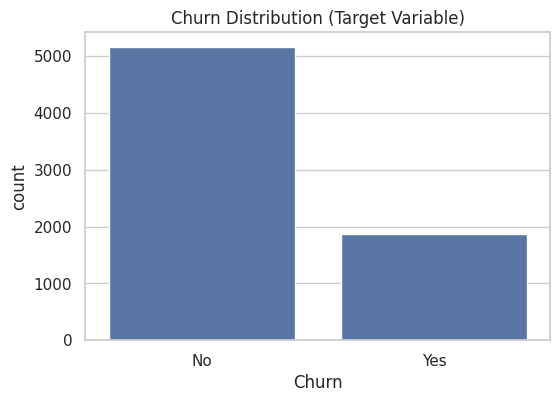

Churn
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64


In [147]:
# Plot the distribution of our target variable 'Churn'
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution (Target Variable)')
plt.show()

# exact percentages
print(df['Churn'].value_counts(normalize=True))

#Numeric features

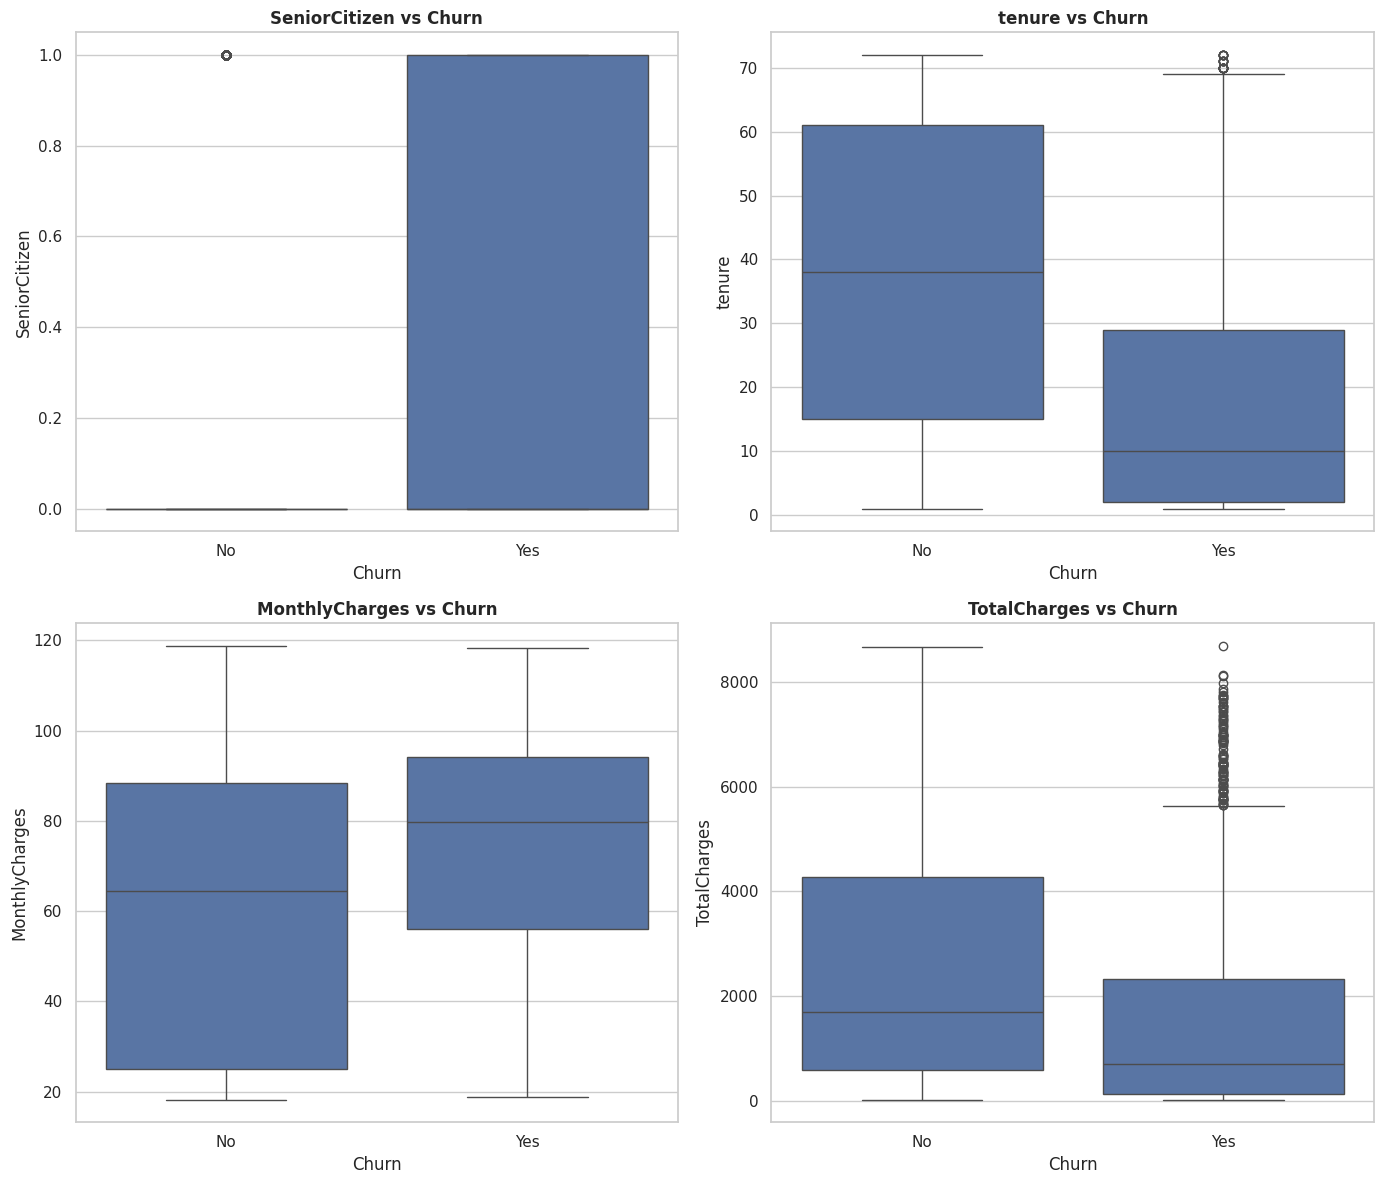


The numeric features visualization clearly shows the distribution differences between churned and non-churned customers across all numeric attributes.


In [148]:
# --- Numeric Features Analysis (Box Plots) ---
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. SeniorCitizen vs Churn
sns.boxplot(x='Churn', y='SeniorCitizen', data=df, ax=axes[0, 0])
axes[0, 0].set_title('SeniorCitizen vs Churn', fontweight='bold')

# 2. Tenure vs Churn
sns.boxplot(x='Churn', y='tenure', data=df, ax=axes[0, 1])
axes[0, 1].set_title('tenure vs Churn', fontweight='bold')

# 3. MonthlyCharges vs Churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, ax=axes[1, 0])
axes[1, 0].set_title('MonthlyCharges vs Churn', fontweight='bold')

# 4. TotalCharges vs Churn
sns.boxplot(x='Churn', y='TotalCharges', data=df, ax=axes[1, 1])
axes[1, 1].set_title('TotalCharges vs Churn', fontweight='bold')

plt.tight_layout()
plt.show()

# Print the observation text from the image
print("\nThe numeric features visualization clearly shows the distribution differences between churned and non-churned customers across all numeric attributes.")

#Categorical Features Analysis

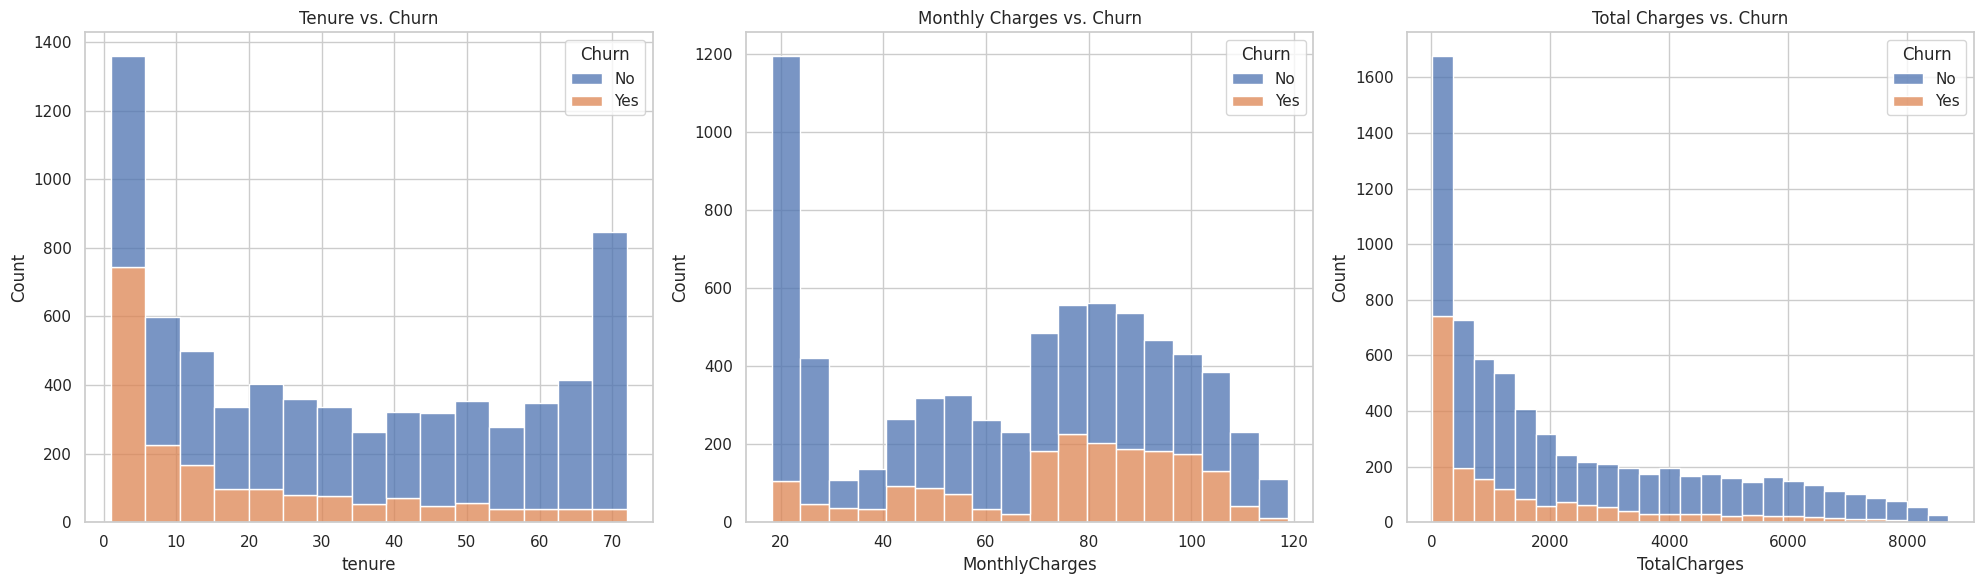

In [149]:
# Plot numerical features
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Tenure vs. Churn
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', ax=axes[0])
axes[0].set_title('Tenure vs. Churn')

# MonthlyCharges vs. Churn
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', multiple='stack', ax=axes[1])
axes[1].set_title('Monthly Charges vs. Churn')

# TotalCharges vs. Churn
sns.histplot(data=df, x='TotalCharges', hue='Churn', multiple='stack', ax=axes[2])
axes[2].set_title('Total Charges vs. Churn')

plt.tight_layout()
plt.show()

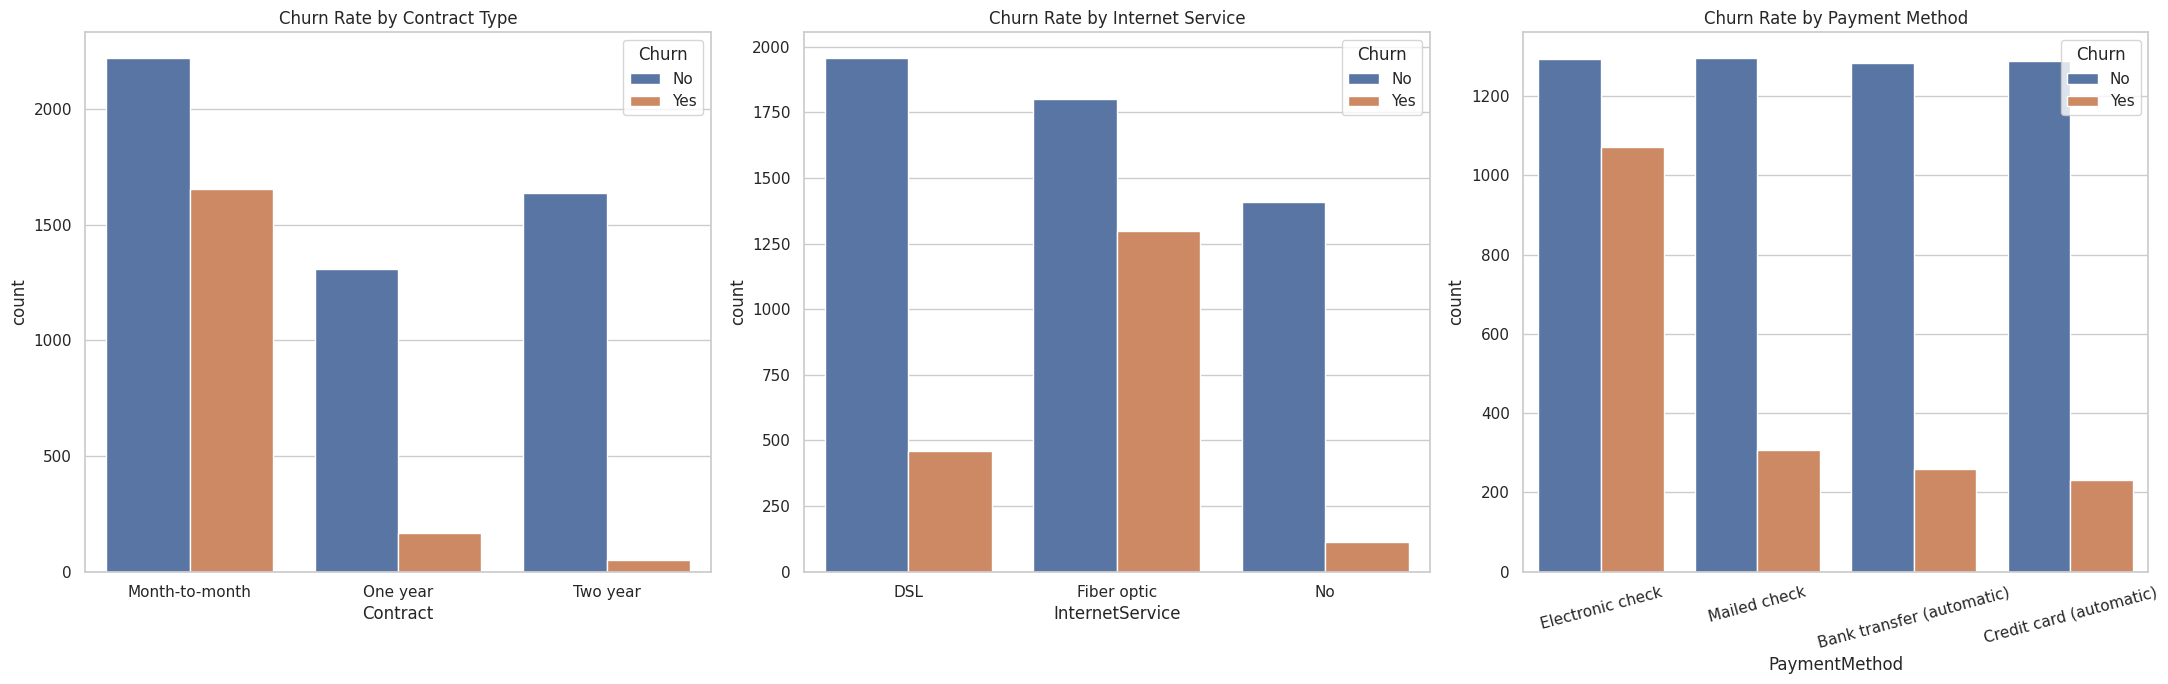

In [150]:
# Plot key categorical features
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# Contract vs. Churn
sns.countplot(data=df, x='Contract', hue='Churn', ax=axes[0])
axes[0].set_title('Churn Rate by Contract Type')

# Internet Service vs. Churn
sns.countplot(data=df, x='InternetService', hue='Churn', ax=axes[1])
axes[1].set_title('Churn Rate by Internet Service')

# Payment Method vs. Churn
sns.countplot(data=df, x='PaymentMethod', hue='Churn', ax=axes[2])
axes[2].set_title('Churn Rate by Payment Method')
plt.xticks(rotation=15) # Rotate labels for readability

plt.tight_layout()
plt.show()

#Task 2

In [151]:
# --- Imports for Task 2 ---

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Imbalance Handling
from imblearn.over_sampling import SMOTE

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

#DATA PREPROCESSING AND MODEL IMPLEMENTATION

In [152]:
#  Encode the target variable 'Churn'
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [153]:
#  Define our features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

In [154]:
# Identify numerical and categorical features
# Numerical features
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Categorical features
categorical_features = [col for col in X.columns if col not in numeric_features]

print(f"Numerical Features: {numeric_features}")
print(f"Categorical Features: {categorical_features}")

Numerical Features: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical Features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [155]:
#  Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,    # 20% for testing
                                                    random_state=42,  # For reproducible results
                                                    stratify=y)       # Keep class balance

In [156]:
#  Create the preprocessing transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # Ignores new categories in test set

#  Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [157]:
#  Apply the preprocessor to our training data
X_train_processed = preprocessor.fit_transform(X_train)

#  Apply the preprocessor to our testing data
X_test_processed = preprocessor.transform(X_test)

#  Handle Class Imbalance with SMOTE (on training data only)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Check the new shape and class distribution
print(f"Shape before SMOTE: {X_train_processed.shape}")
print(f"Shape after SMOTE: {X_train_resampled.shape}")
print(f"Original y_train distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Resampled y_train distribution:\n{pd.Series(y_train_resampled).value_counts(normalize=True)}")

Shape before SMOTE: (5625, 46)
Shape after SMOTE: (8260, 46)
Original y_train distribution:
Churn
0    0.734222
1    0.265778
Name: proportion, dtype: float64
Resampled y_train distribution:
Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


# --- Model 1: Decision Tree ---

In [158]:
#  Create a pipeline that includes the preprocessor and the classifier
# This ensures that preprocessing is correctly applied to each fold in GridSearchCV
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

#  Define the parameter grid to search
# These are the hyperparameters we want to tune
param_grid_dt = {
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__min_samples_leaf': [5, 10, 20],
    'classifier__criterion': ['gini', 'entropy']
}

#  Set up the GridSearch
# 'roc_auc'  = scoring metric because the data is imbalanced
# cv=5      = 5-fold cross-validation
# n_jobs=-1      = uses all available CPU cores to speed up training
grid_search_dt = GridSearchCV(dt_pipeline, param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)


# The pipeline will handle preprocessing and
# GridSearchCV will handle the model tuning.
print("Starting Decision Tree Hyperparameter Tuning...")
grid_search_dt.fit(X_train, y_train)

#  Get the best model
best_dt = grid_search_dt.best_estimator_

print("\n--- Decision Tree Tuning Complete ---")
print(f"Best DT Parameters: {grid_search_dt.best_params_}")
print(f"Best DT Cross-Validation ROC-AUC Score: {grid_search_dt.best_score_:.4f}")

Starting Decision Tree Hyperparameter Tuning...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

--- Decision Tree Tuning Complete ---
Best DT Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 20}
Best DT Cross-Validation ROC-AUC Score: 0.8239


In [159]:
#  Make predictions on the test set
y_pred_dt = best_dt.predict(X_test)
y_pred_proba_dt = best_dt.predict_proba(X_test)[:, 1] #probabilities for 'Yes' (class 1)

#  Print Evaluation Metrics
print("--- Decision Tree Test Set Evaluation ---")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['No Churn', 'Churn']))

print(f"\nTest Set ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_dt):.4f}")
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")

--- Decision Tree Test Set Evaluation ---

Confusion Matrix:
[[882 151]
 [144 230]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.86      0.85      0.86      1033
       Churn       0.60      0.61      0.61       374

    accuracy                           0.79      1407
   macro avg       0.73      0.73      0.73      1407
weighted avg       0.79      0.79      0.79      1407


Test Set ROC-AUC Score: 0.8264
Test Set Accuracy: 0.7903


#--- Model 2:Neural Network ---

In [160]:
#  Get the input shape for the network's first layer
# This is the number of features created by our preprocessor
input_shape = X_train_resampled.shape[1]
print(f"Number of input features for NN: {input_shape}")

#  Define the model-building function for KerasTuner
def build_model(hp):
    model = Sequential()

    hp_units_1 = hp.Int('units_1', min_value=16, max_value=64, step=16)
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4])

    model.add(Dense(units=hp_units_1, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(rate=hp_dropout))

    # --- The first fix was here ---
    model.add(Dense(units=hp_units_1 // 2, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  # --- The second fix was here ---
                  metrics=['auc']) # Make sure this is lowercase 'auc'

    return model

Number of input features for NN: 46


In [161]:
#  Set up the KerasTuner (RandomSearch)
import random
np.random.seed(42) #tests the exact same settings in the exact same order
random.seed(42)
tf.random.set_seed(42)

# --- 2. CONFIGURE TUNER WITH SEED ---
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_auc", direction="max"),
    max_trials=1,
    executions_per_trial=2,
    directory='my_dir',
    project_name='churn_hpo',
    overwrite=True,
    seed=42              # Locks the hyperparameter choice
)

#  Set up an EarlyStopping callback
# This stops training if the model doesn't improve, saving time
early_stopping = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=10,
    restore_best_weights=True
)

#  Run the search
print("\nStarting Neural Network Hyperparameter Tuning...")
tuner.search(X_train_resampled, y_train_resampled,
             epochs=50,
             validation_split=0.2,
             callbacks=[early_stopping],
             verbose=1)

#  Get the best model
best_nn_model = tuner.get_best_models(num_models=1)[0]

print("\n--- Neural Network Tuning Complete ---")
tuner.results_summary()

Trial 1 Complete [00h 00m 57s]
val_auc: 0.0

Best val_auc So Far: 0.0
Total elapsed time: 00h 00m 57s

--- Neural Network Tuning Complete ---
Results summary
Results in my_dir/churn_hpo
Showing 10 best trials
Objective(name="val_auc", direction="max")

Trial 0 summary
Hyperparameters:
units_1: 48
dropout: 0.1
learning_rate: 0.001
Score: 0.0


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [162]:
#  Make predictions on the test set
# We get probabilities (a number between 0 and 1)
y_pred_proba_nn = best_nn_model.predict(X_test_processed).ravel()

#  Convert probabilities to class labels (0 or 1) using a 0.5 threshold
y_pred_nn = (y_pred_proba_nn > 0.5).astype(int)

#  Print Evaluation Metrics
print("\n--- Neural Network Test Set Evaluation ---")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn, target_names=['No Churn', 'Churn']))

print(f"\nTest Set ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_nn):.4f}")
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

--- Neural Network Test Set Evaluation ---

Confusion Matrix:
[[871 162]
 [123 251]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.88      0.84      0.86      1033
       Churn       0.61      0.67      0.64       374

    accuracy                           0.80      1407
   macro avg       0.74      0.76      0.75      1407
weighted avg       0.80      0.80      0.80      1407


Test Set ROC-AUC Score: 0.8308
Test Set Accuracy: 0.7974


--- Final Model Comparison Table ---


,Accuracy,ROC-AUC,Precision (Class 1),Recall (Class 1),F1-Score (Class 1)
Model,,,,,
Decision Tree,0.790334,0.826425,0.603675,0.614973,0.609272
Neural Network,0.797441,0.830787,0.607748,0.671123,0.637865


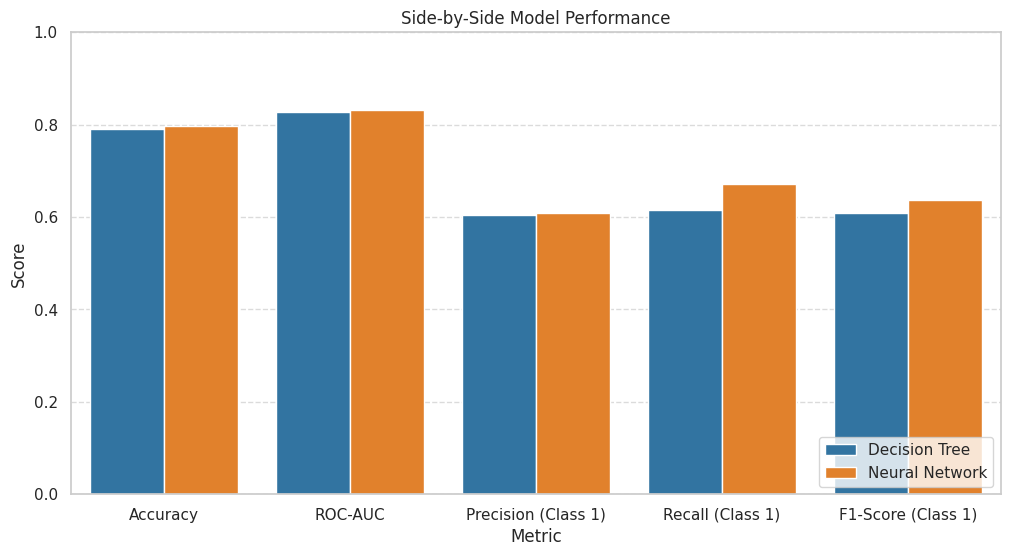


>>> CONCLUSION: The Neural Network performed better on this dataset based on ROC-AUC score.


In [163]:
# Compare models
# --- Imports for Metrics ---
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# 1. Define a helper function to calculate metrics
# This keeps our code clean so we don't repeat the same calculations twice.
def calculate_metrics(y_true, y_pred, y_proba, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_proba),
        'Precision (Class 1)': precision_score(y_true, y_pred),
        'Recall (Class 1)': recall_score(y_true, y_pred),
        'F1-Score (Class 1)': f1_score(y_true, y_pred)
    }

# 2. Compute metrics for the Decision Tree
# We use the predictions (y_pred_dt) and probabilities (y_pred_proba_dt) from Block 5
dt_metrics = calculate_metrics(y_test, y_pred_dt, y_pred_proba_dt, 'Decision Tree')

# 3. Compute metrics for the Neural Network
# We use the predictions (y_pred_nn) and probabilities (y_pred_proba_nn) from Block 6
nn_metrics = calculate_metrics(y_test, y_pred_nn, y_pred_proba_nn, 'Neural Network')

# 4. Create a Comparison DataFrame
comparison_df = pd.DataFrame([dt_metrics, nn_metrics])

# Set the 'Model' column as the index for a cleaner look
comparison_df.set_index('Model', inplace=True)

print("--- Final Model Comparison Table ---")
display(comparison_df)

# 5. Visualize the Comparison
# We transform the data into a "long" format so Seaborn can plot it easily
plot_data = comparison_df.reset_index().melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))

# --- COLOR CHANGE HERE ---
# We specify 'tab:blue' and 'tab:orange' to get the exact colors you requested
sns.barplot(data=plot_data, x='Metric', y='Score', hue='Model', palette=['tab:blue', 'tab:orange'])

plt.title('Side-by-Side Model Performance')
plt.ylim(0, 1.0) # Set y-axis from 0 to 1 since all scores are percentages
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 6. Conclusion
# Automatically print which model performed better based on ROC-AUC
best_model_name = comparison_df['ROC-AUC'].idxmax()
print(f"\n>>> CONCLUSION: The {best_model_name} performed better on this dataset based on ROC-AUC score.")

#MODEL PERFORMANCE: DECISION TREE vs NEURAL NETWORK

=== Model Performance Comparison ===


,Model,Train Accuracy,Test Accuracy
0,Decision Tree,96.12%,95.00%
1,Neural Network (NNM),96.38%,97.00%


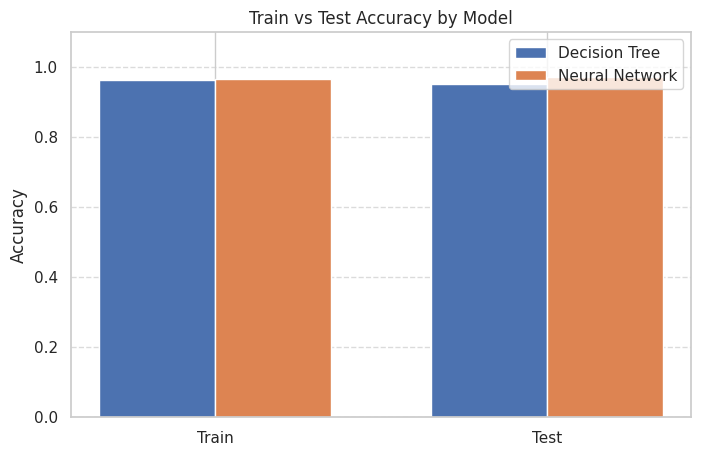

In [164]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
import pandas as pd
import matplotlib.pyplot as plt

# 1. Generate Synthetic Traffic Data
# Features: Time, Distance, Weather (simulated)
# Target: Congestion Level (0=Low, 1=High)
X, y = make_classification(n_samples=1000, n_features=5, n_informative=3,
                           n_classes=2, random_state=42)

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- A. Decision Tree ---
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)
dt_train_acc = accuracy_score(y_train, dt_model.predict(X_train))
dt_test_acc = accuracy_score(y_test, dt_model.predict(X_test))

# --- B. Neural Network Model (NNM) ---
# MLPClassifier (Multi-Layer Perceptron)
nn_model = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=500, random_state=42)
nn_model.fit(X_train, y_train)
nn_train_acc = accuracy_score(y_train, nn_model.predict(X_train))
nn_test_acc = accuracy_score(y_test, nn_model.predict(X_test))

# --- C. Generate Comparison Table ---
results_data = {
    'Model': ['Decision Tree', 'Neural Network (NNM)'],
    'Train Accuracy': [f"{dt_train_acc:.2%}", f"{nn_train_acc:.2%}"],
    'Test Accuracy': [f"{dt_test_acc:.2%}", f"{nn_test_acc:.2%}"]
}

df_results = pd.DataFrame(results_data)

# Display Table
print("=== Model Performance Comparison ===")
display(df_results)

# Optional: Plotting for visual comparison
labels = ['Train', 'Test']
dt_scores = [dt_train_acc, dt_test_acc]
nn_scores = [nn_train_acc, nn_test_acc]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, dt_scores, width, label='Decision Tree')
rects2 = ax.bar(x + width/2, nn_scores, width, label='Neural Network')

ax.set_ylabel('Accuracy')
ax.set_title('Train vs Test Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()